In [1]:
import tensorflow as tf
import numpy as np
import IPython.display as display
from PIL import Image
import io
from matplotlib import colors

In [2]:
# first load the dataset and figure out how big it is...
datasetFileName = 'ralpn_a.tfrecords'
dataset = tf.data.TFRecordDataset(datasetFileName)

In [3]:
# count number of examples in this dataset
numExamples = sum([1 for i in dataset])

In [4]:
# the dataset is just a bunch of serialized images and classification masks ('labels')
# we need to convert data back into images and make an actual dataset to be fed into the CNN
# mostly from: https://docs.microsoft.com/en-us/azure/databricks/_static/notebooks/deep-learning/mnist-tfrecords-to-tensorflow.html
# this is directly from the Kaggle notebook
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# Create a dictionary describing the features.
image_feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'class': tf.io.FixedLenFeature([], tf.string)
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_dataset = dataset.map(_parse_image_function)
view_dataset = parsed_dataset # so we don't use up the iterator
parsed_dataset

<MapDataset shapes: {class: (), image: ()}, types: {class: tf.string, image: tf.string}>

In [5]:
def apply_mask_to_image(image_arr,mask_arr):
    mask_colors = np.array([[0, 0, 0], [255,191,0], [0,255,0], [255,84,84], [84,84,255]])/255.0
    image_hsv_arr = colors.rgb_to_hsv(image_arr.astype(np.float)/255.0)
    mask_slice = mask_arr[:,:,0]
    
    for labelIdx in range(5):
        
        # get label_mask
        label_mask = (mask_slice == labelIdx)
        #print(label_mask)
        
        # get color
        this_color_hsv = colors.rgb_to_hsv(mask_colors[labelIdx,:])
        
        # update hue
        image_hsv_arr[:,:,0] = image_hsv_arr[:,:,0] + np.multiply(this_color_hsv[0], label_mask)
        
        # update saturation
        image_hsv_arr[:,:,1] = image_hsv_arr[:,:,1] + np.multiply(this_color_hsv[1], label_mask)
    
    new_image =  colors.hsv_to_rgb(image_hsv_arr)*255.0
        
    return new_image.astype(np.uint8)
    

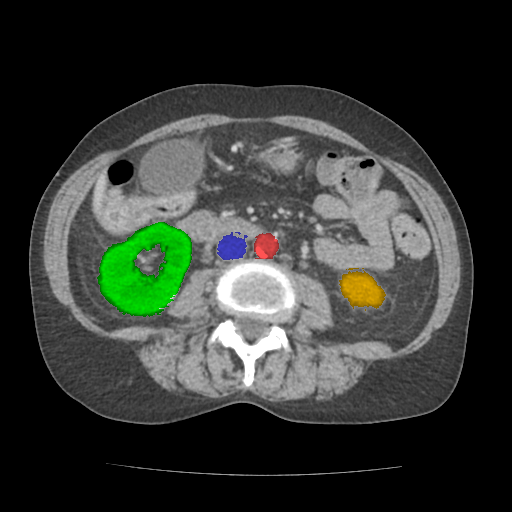

In [7]:
# look at an example image
for image_features in view_dataset.take(1):
    image = image_features['image'].numpy()
    #display.display(display.Image(data=image))
    label = image_features['class'].numpy()
    #display.display(display.Image(data=label))
    
    image2 = Image.open(io.BytesIO(image))
    image_arr = np.asarray(image2)
    #print(image_arr.shape)
    #display.display(Image.fromarray(image_arr))   #### EASIEST WAY TO DISPLAY AN IMAGE FROM A NUMPY ARRAY!!! #########

    label2 = Image.open(io.BytesIO(label))
    label_arr_raw = np.asarray(label2)
    #label_arr = np.multiply(label_arr_raw.astype(float), (255.0/4.0) ).astype(np.uint8)
    #display.display(Image.fromarray(label_arr))
    
    image_masked_arr = apply_mask_to_image(image_arr,label_arr_raw)
    display.display(Image.fromarray(image_masked_arr))
    

In [8]:

# https://stackoverflow.com/questions/51125266/how-do-i-split-tensorflow-datasets
#train_size = int(0.7 * DATASET_SIZE)
#val_size = int(0.15 * DATASET_SIZE)
#test_size = int(0.15 * DATASET_SIZE)

#full_dataset = tf.data.TFRecordDataset(FLAGS.input_file)
#full_dataset = full_dataset.shuffle()
#train_dataset = full_dataset.take(train_size)
#test_dataset = full_dataset.skip(train_size)
#val_dataset = test_dataset.skip(test_size)
#test_dataset = test_dataset.take(test_size)

In [9]:
# try a bunch of stuff
myarr = np.array([[1,2],[3,4]])
print(myarr == 2)
myarr2 = np.multiply(myarr,(myarr==2))
print(myarr2)

for i in range(5):
    print(i)
    
    
myarr3d = np.array([ [[1,1],[1,1]], [[2,2],[2,2]], [[3,3],[3,3]] ])
print(myarr3d)
print(myarr3d.shape)
myarr3d_slice = myarr3d[0,:,:]

print(myarr3d_slice)

mycolors = np.array([[0, 0, 0], [255,191,255], [0,255,0], [255,84,84], [84,84,255]])
print(mycolors[1,:])
print(colors.rgb_to_hsv(mycolors[1,:]))

myarr2d = myarr3d[0,:,:] + myarr3d[1,:,:]
print(myarr2d)

np.ones((4,4))
np.ones(myarr2d.shape)

[[False  True]
 [False False]]
[[0 2]
 [0 0]]
0
1
2
3
4
[[[1 1]
  [1 1]]

 [[2 2]
  [2 2]]

 [[3 3]
  [3 3]]]
(3, 2, 2)
[[1 1]
 [1 1]]
[255 191 255]
[8.33333333e-01 2.50980392e-01 2.55000000e+02]
[[3 3]
 [3 3]]


array([[1., 1.],
       [1., 1.]])

In [10]:
myarr2d = np.array([[1,2],[3,4]])
print(myarr2d)
myarr2d[0,:] = myarr2d[0,:] + np.ones(myarr2d[0,:].shape)
print(myarr2d)

red = np.array([255,0,0])
print(red)
red_hsv = colors.rgb_to_hsv(red/255.0)
print(red_hsv)

[[1 2]
 [3 4]]
[[2 3]
 [3 4]]
[255   0   0]
[0. 1. 1.]


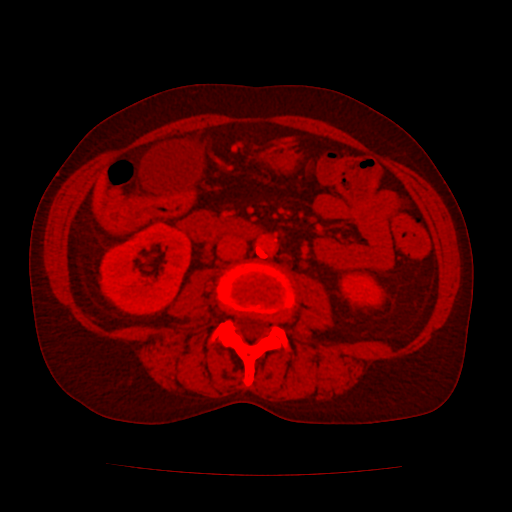

In [11]:
#display.display(Image.fromarray(image_arr))
#np.amax(image_arr)
image_arr_hsv = colors.rgb_to_hsv(image_arr.astype(np.float)/255.0)
image_arr_hsv[:,:,1] =  image_arr_hsv[:,:,1] + np.ones(image_arr_hsv[:,:,1].shape)
image_arr_red = colors.hsv_to_rgb(image_arr_hsv)
image_arr_red_uint8 = (image_arr_red*255.0).astype(np.uint8)
display.display(Image.fromarray(image_arr_red_uint8))